Исходная матрица A:
4×4 Matrix{Float64}:
 2.2  1.0  0.5  2.0
 1.0  1.3  2.0  1.0
 0.5  2.0  0.5  1.6
 2.0  1.0  1.6  2.0

Интервалы Гершгорина: [[-1.2999999999999998, 5.7], [-2.7, 5.3], [-3.5999999999999996, 4.6], [-2.5999999999999996, 6.6]]
Интервал Гершгорина (объединённый): [[-3.5999999999999996, 6.6]]

Коэффициенты характеристического многочлена: [1.0, -6.000000000000001, -0.20000000000000284, 12.735000000000014, -2.7616000000000085]

Собственные значения: [-1.420086593955995, 0.22263592711062552, 1.5454183350500004, 5.6520323317348335]



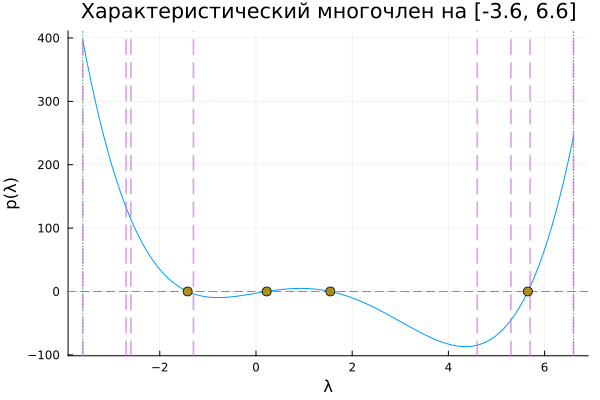

Собственные векторы
4×4 Matrix{Float64}:
 -0.222043  -0.521921   0.62893   0.531736
  0.51591   -0.454869  -0.572574  0.446194
 -0.757274   0.153447  -0.485654  0.408816
  0.333271   0.705086   0.201858  0.592484

Проверка следа матрицы: (сумма λ = 5.999999999939464, tr(A) = 6.0)
Проверка ортогональности: ОК


In [5]:
using Random
using LinearAlgebra
using Plots

euclidean_norm(vec::AbstractVector) = sqrt(sum(abs2, vec))
identity_matrix(n::Int) = Matrix{Float64}(I, n, n)

function generate_symmetric_matrix(l::Real, r::Real, n::Int)
    A = rand(n, n) .* (r - l) .+ l
    (A + A') / 2
end

function danilevsky_algorithm(A)
    n = size(A, 1)
    B = Matrix{Float64}(I, n, n)
    P = copy(A)
    
    for k in n:-1:2        
        B_k = Matrix{Float64}(I, n, n)
        for j in 1:n
            if j != k-1
                B_k[k-1, j] = -P[k, j] / P[k, k-1]
            else
                B_k[k-1, j] = 1.0 / P[k, k-1]
            end
        end
        
        B_k_inverted = Matrix{Float64}(I, n, n)
        for j in 1:n
            B_k_inverted[k-1, j] = P[k, j]
        end
        
        P = B_k_inverted * P * B_k
        B = B * B_k
    end
    
    return B, P
end

function union_intervals(intervals::Vector{Vector{Float64}})
    isempty(intervals) && return Vector{Vector{Float64}}()
    s = sort(intervals, by = x -> x[1])
    merged = [copy(s[1])]
    for v in s[2:end]
        last = merged[end]
        if last[2] >= v[1]
            last[2] = max(last[2], v[2])
        else
            push!(merged, copy(v))
        end
    end
    merged
end

function gershgorin_intervals_raw(A::Matrix{Float64})
    n = size(A, 1)
    ivs = Vector{Vector{Float64}}(undef, n)
    for i in 1:n
        r = sum(abs.(A[i, :])) - abs(A[i, i])
        c = A[i, i]
        ivs[i] = [c - r, c + r]
    end
    ivs
end

function gershgorin_intervals(A::Matrix{Float64})
    union_intervals(gershgorin_intervals_raw(A))
end

find_equation_coeffs(D::Matrix{Float64}) = vcat(1.0, -D[1, :])

function poly_eval(coeffs::AbstractVector{<:Real}, x::Real)
    acc = 0.0
    for c in coeffs
        acc = acc * x + c
    end
    acc
end

function find_real_roots_on_intervals(coeffs::Vector{Float64},
                                      intervals::Vector{Vector{Float64}};
                                      step::Real = 1e-2, tol::Real = 1e-8)
    roots = Float64[]
    for I in intervals
        a, b = I
        x = a
        prev_y = poly_eval(coeffs, x)
        while x < b - step/2
            x_next = min(x + step, b)
            y_next = poly_eval(coeffs, x_next)
            if prev_y == 0.0
                push!(roots, x)
            elseif y_next == 0.0
                push!(roots, x_next)
            elseif prev_y * y_next < 0
                left, right = x, x_next
                yl = prev_y
                while right - left > tol
                    mid = (left + right) / 2
                    ym  = poly_eval(coeffs, mid)
                    if yl * ym <= 0
                        right = mid
                    else
                        left = mid
                        yl   = ym
                    end
                end
                push!(roots, (left + right) / 2)
            end
            x = x_next
            prev_y = y_next
        end
    end
    sort!(unique!(round.(roots; digits=10)))
    roots
end

function eigenvectors_from_Bs(Bs::Matrix{Float64}, eigvals::AbstractVector{<:Real})
    n = size(Bs, 1)
    X = Matrix{Float64}(undef, n, length(eigvals))
    for (k, λ) in pairs(eigvals)
        v = [λ^(n - i) for i in 1:n]
        x = Bs * v
        nrm = euclidean_norm(x)
        nrm > 0 && (x ./= nrm)
        X[:, k] = x
    end
    X
end

function check_trace(A::Matrix{Float64}, eigvals::AbstractVector{<:Real}; tol=1e-5)
    sλ = sum(eigvals)
    traceA = LinearAlgebra.tr(A)
    if abs(sλ - traceA) <= tol * max(1.0, abs(traceA))
        println("Проверка следа матрицы: (сумма λ = $(sλ), tr(A) = $(traceA))")
    else
        println("Проверка следа матриця: ОШИБКА (сумма λ = $(sλ), tr(A) = $(traceA))")
    end
end

function check_orthogonality(X::Matrix{Float64}; tol=1e-6)
    m = size(X, 2)
    for i in 1:m-1, j in i+1:m
        d = dot(X[:, i], X[:, j])
        if abs(d) > tol
            println("Проверка ортогональности: ОШИБКА (⟨e$i, e$j⟩ = $d)")
            return
        end
    end
    println("Проверка ортогональности: ОК")
end

function make_plot(coeffs::Vector{Float64},
                                     merged_intervals::Vector{Vector{Float64}};
                                     samples::Int = 2000,
                                     roots::AbstractVector{<:Real} = Float64[],
                                     raw_intervals::Vector{Vector{Float64}} = Vector{Vector{Float64}}())
    a_min = minimum(I[1] for I in merged_intervals)
    b_max = maximum(I[2] for I in merged_intervals)
    xs = range(a_min, b_max; length=samples)
    ys = [poly_eval(coeffs, x) for x in xs]

    plt = plot(xs, ys, legend=false, xlabel="λ", ylabel="p(λ)",
               title = "Характеристический многочлен на [$(round(a_min, digits=3)), $(round(b_max, digits=3))]")
    hline!(plt, [0.0], linestyle=:dash)
    vline!(plt, [a_min, b_max], linestyle=:dot)

    if !isempty(raw_intervals)
        bounds = reduce(vcat, raw_intervals)
        vline!(plt, bounds; linestyle=:dash, alpha=0.6, linewidth=1.8)
    end

    if !isempty(roots)
        scatter!(plt, roots, zeros(length(roots)); markersize=5)
    end
    display(plt)
end


function main()
    Random.seed!(42)
    n = 4
    #A = generate_symmetric_matrix(-5, 5, n)
    A = [2.2  1.0  0.5  2.0;
     1.0  1.3  2.0  1.0;
     0.5  2.0  0.5  1.6;
     2.0  1.0  1.6  2.0]
    println("Исходная матрица A:")
    show(stdout, "text/plain", round.(A; digits=4))
    println("\n")

    raw_intervals = gershgorin_intervals_raw(A)
    println("Интервалы Гершгорина: ", raw_intervals)
    intervals = union_intervals(copy(raw_intervals))
    println("Интервал Гершгорина (объединённый): ", intervals, "\n")
    Bs, Df = danilevsky_algorithm(A)
    coeffs = find_equation_coeffs(Df)
    println("Коэффициенты характеристического многочлена: ", coeffs, "\n")
    eig_vals = find_real_roots_on_intervals(coeffs, intervals; step=1e-3, tol=1e-10)
    println("Собственные значения: ", eig_vals, "\n")

    make_plot(coeffs, intervals;
    samples=3000, roots=eig_vals, raw_intervals=raw_intervals)
    if length(eig_vals) < n
        println("ВНИМАНИЕ: найдено меньше собственных значений, чем n = $n.")
        return
    end
    X = eigenvectors_from_Bs(Bs, eig_vals)

    println("Собственные векторы")
    show(stdout, "text/plain", round.(X; digits=6))
    println("\n")

    check_trace(A, eig_vals; tol=1e-8)
    check_orthogonality(X; tol=1e-6)
end

main()
